# Analysis correlation among municipal attributes and mortality rate
## Workflow: execute after the notebok 01_prepare_dataset_sociodemographic_covid

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from datetime import  timedelta

import util
from util import get_default_colors_heatmap
import matplotlib.dates as mdates

## Loading data

In [2]:
df = pd.read_csv('data/df_sociodemographic_covid.csv', index_col=0)
df.CODIGO_MUNICIPIO_6 = df.CODIGO_MUNICIPIO_6.astype('Int64')

In [3]:
ts_covid = pd.read_csv('../covid/data/output/df_sim_covid_deaths_municipal_timeseries.csv')
ts_covid.DATA = pd.to_datetime(ts_covid.DATA, infer_datetime_format=True)
ts_covid.CODIGO_MUNICIPIO_6 = ts_covid.CODIGO_MUNICIPIO_6.astype('Int64')
ts_covid = ts_covid.sort_values('DATA')
ts_covid

,DATA,CODIGO_MUNICIPIO_6,OBITOS_NOVOS,OBITOS,MUNICIPIO,SIGLA_ESTADO,ESTADO,REGIAO,POPULACAO_2022,TAXA_OBITOS_NOVOS,TAXA_OBITOS
0,2020-03-12,355030,1,1,São Paulo,SP,São Paulo,Sudeste,11451245.0,0.008733,0.008733
3725,2020-03-12,421510,0,0,Rodeio,SC,Santa Catarina,Sul,12757.0,0.000000,0.000000
3724,2020-03-12,150085,0,0,Anapu,PA,Pará,Norte,31850.0,0.000000,0.000000
3723,2020-03-12,431171,0,0,Maçambará,RS,Rio Grande do Sul,Sul,4425.0,0.000000,0.000000
3722,2020-03-12,431805,0,0,São Domingos do Sul,RS,Rio Grande do Sul,Sul,2754.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
5716800,2022-12-31,312870,0,191,Guaxupé,MG,Minas Gerais,Sudeste,50911.0,0.000000,375.164503
5716799,2022-12-31,313867,0,22,Luisburgo,MG,Minas Gerais,Sudeste,6956.0,0.000000,316.273721
5716798,2022-12-31,432195,0,20,Trindade do Sul,RS,Rio Grande do Sul,Sul,7556.0,0.000000,264.690312
5716806,2022-12-31,432100,0,51,Tapera,RS,Rio Grande do Sul,Sul,10592.0,0.000000,481.495468


In [4]:
ts_covid.OBITOS_NOVOS.sum()

700952

In [5]:
df_base = pd.read_csv('../covid/data/output/df_municpal.csv')
df_base.CODIGO_MUNICIPIO_6 = df_base.CODIGO_MUNICIPIO_6.astype('Int64')
df_base

,MUNICIPIO,CODIGO_MUNICIPIO_6,SIGLA_ESTADO,CODIGO_ESTADO,REGIAO,REGIAO_SAUDE,CODIGO_REGIAO_SAUDE,REGIAO_METROPOLITANA,ESTADO,CODIGO_MUNICIPIO_7,...,TAXA_MEDICOS_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_VENTILADORES_RESPIRADORES_EM_USO_2019_12_REGIAO_INTERMEDIARIA,PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_SEM_BANHEIRO_AGUA,PERCENTUAL_TRABALHADORES_INFORMAIS,PERCENTUAL_OCUPADOS_SERVICO_COMERCIO,DENSIDADE_URBANA,DENSIDADE_RURAL,POPULACAO_2022,REGIAO_EN
0,Alta Floresta D'Oeste,110001,RO,11,Norte,ZONA DA MATA,11005.0,0.0,Rondônia,1100015,...,127.561671,99.171813,11.433020,19.80,58.32,46.96,1378.1456,1.4622,21495,North
1,Ariquemes,110002,RO,11,Norte,VALE DO JAMARI,11001.0,0.0,Rondônia,1100023,...,153.988174,115.040580,28.634992,14.65,47.19,58.05,1573.2716,3.1209,96833,North
2,Cabixi,110003,RO,11,Norte,CONE SUL,11006.0,0.0,Rondônia,1100031,...,127.561671,99.171813,11.433020,8.37,60.62,43.37,1712.9959,2.7400,5363,North
3,Cacoal,110004,RO,11,Norte,CAFE,11002.0,0.0,Rondônia,1100049,...,127.561671,99.171813,11.433020,6.56,44.93,58.07,1403.7959,4.4070,86895,North
4,Cerejeiras,110005,RO,11,Norte,CONE SUL,11006.0,0.0,Rondônia,1100056,...,127.561671,99.171813,11.433020,13.13,54.46,52.47,908.6033,0.9359,15890,North
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,Vianópolis,522200,GO,52,Centro-Oeste,CENTRO SUL,52002.0,0.0,Goiás,5222005,...,234.593248,118.243874,28.200988,0.61,50.59,51.85,1133.3305,3.5546,14956,Midwestern
5566,Vicentinópolis,522205,GO,52,Centro-Oeste,CENTRO SUL,52002.0,0.0,Goiás,5222054,...,127.162239,85.335718,15.865232,10.07,41.65,45.18,1379.0329,1.4297,8768,Midwestern
5567,Vila Boa,522220,GO,52,Centro-Oeste,ENTORNO NORTE,52003.0,0.0,Goiás,5222203,...,78.632387,64.866314,2.810874,6.57,38.76,38.38,2364.8666,1.1567,4215,Midwestern
5568,Vila Propício,522230,GO,52,Centro-Oeste,SAO PATRICIO II,52018.0,0.0,Goiás,5222302,...,103.794433,104.560444,12.256169,9.89,62.74,34.13,1220.0670,1.6635,5815,Midwestern


In [6]:
df_dates = ts_covid[['DATA']].drop_duplicates()

In [7]:
df_dates

,DATA
0,2020-03-12
9299,2020-03-13
14881,2020-03-14
20467,2020-03-15
26044,2020-03-16
...,...
5696338,2022-12-27
5701920,2022-12-28
5707500,2022-12-29
5713083,2022-12-30


In [8]:
df_base.groupby('REGIAO')[['PERCENTUAL_POPULACAO_15_A_24_ANOS', 'PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS', 'GINI']].median()

,PERCENTUAL_POPULACAO_15_A_24_ANOS,PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS,GINI
REGIAO,,,
Centro-Oeste,17.355,10.525,0.49
Nordeste,19.275,11.415,0.52
Norte,19.700,7.620,0.56
Sudeste,17.010,13.080,0.46
Sul,16.590,13.835,0.46


In [9]:
correlation, pvalue = spearmanr(df_base[['PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS', 'GINI']].dropna())

In [10]:
correlation

-0.3537447956405515

In [11]:
round(pvalue,4)

0.0

In [12]:
df_base

,MUNICIPIO,CODIGO_MUNICIPIO_6,SIGLA_ESTADO,CODIGO_ESTADO,REGIAO,REGIAO_SAUDE,CODIGO_REGIAO_SAUDE,REGIAO_METROPOLITANA,ESTADO,CODIGO_MUNICIPIO_7,...,TAXA_MEDICOS_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_VENTILADORES_RESPIRADORES_EM_USO_2019_12_REGIAO_INTERMEDIARIA,PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_SEM_BANHEIRO_AGUA,PERCENTUAL_TRABALHADORES_INFORMAIS,PERCENTUAL_OCUPADOS_SERVICO_COMERCIO,DENSIDADE_URBANA,DENSIDADE_RURAL,POPULACAO_2022,REGIAO_EN
0,Alta Floresta D'Oeste,110001,RO,11,Norte,ZONA DA MATA,11005.0,0.0,Rondônia,1100015,...,127.561671,99.171813,11.433020,19.80,58.32,46.96,1378.1456,1.4622,21495,North
1,Ariquemes,110002,RO,11,Norte,VALE DO JAMARI,11001.0,0.0,Rondônia,1100023,...,153.988174,115.040580,28.634992,14.65,47.19,58.05,1573.2716,3.1209,96833,North
2,Cabixi,110003,RO,11,Norte,CONE SUL,11006.0,0.0,Rondônia,1100031,...,127.561671,99.171813,11.433020,8.37,60.62,43.37,1712.9959,2.7400,5363,North
3,Cacoal,110004,RO,11,Norte,CAFE,11002.0,0.0,Rondônia,1100049,...,127.561671,99.171813,11.433020,6.56,44.93,58.07,1403.7959,4.4070,86895,North
4,Cerejeiras,110005,RO,11,Norte,CONE SUL,11006.0,0.0,Rondônia,1100056,...,127.561671,99.171813,11.433020,13.13,54.46,52.47,908.6033,0.9359,15890,North
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,Vianópolis,522200,GO,52,Centro-Oeste,CENTRO SUL,52002.0,0.0,Goiás,5222005,...,234.593248,118.243874,28.200988,0.61,50.59,51.85,1133.3305,3.5546,14956,Midwestern
5566,Vicentinópolis,522205,GO,52,Centro-Oeste,CENTRO SUL,52002.0,0.0,Goiás,5222054,...,127.162239,85.335718,15.865232,10.07,41.65,45.18,1379.0329,1.4297,8768,Midwestern
5567,Vila Boa,522220,GO,52,Centro-Oeste,ENTORNO NORTE,52003.0,0.0,Goiás,5222203,...,78.632387,64.866314,2.810874,6.57,38.76,38.38,2364.8666,1.1567,4215,Midwestern
5568,Vila Propício,522230,GO,52,Centro-Oeste,SAO PATRICIO II,52018.0,0.0,Goiás,5222302,...,103.794433,104.560444,12.256169,9.89,62.74,34.13,1220.0670,1.6635,5815,Midwestern


In [13]:
df_base['KEY'] = 0
df_dates['KEY'] = 0
df_cross_dates_base = df_dates.merge(df_base[['KEY','CODIGO_MUNICIPIO_6', 'MUNICIPIO', 'SIGLA_ESTADO', 'PERCENTUAL_POPULACAO_0_A_5_ANOS', 'PERCENTUAL_POPULACAO_6_A_14_ANOS', 'PERCENTUAL_POPULACAO_15_A_24_ANOS', 'PERCENTUAL_POPULACAO_25_A_39_ANOS', 'PERCENTUAL_POPULACAO_40_A_59_ANOS', 'PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS', 'PERCENTUAL_POPULACAO_URBANA', 'IDHM_RENDA', 'GINI', 'TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA', 'TAXA_ATIVIDADE', 'PERCENTUAL_TRABALHADORES_INFORMAIS', 'PERCENTUAL_OCUPADOS_AGROPECUARIA', 'PERCENTUAL_OCUPADOS_COMERCIO', 'PERCENTUAL_OCUPADOS_SERVICO', 'PERCENTUAL_OCUPADOS_INDUSTRIA', 'POPULACAO_2022']], how='outer')
df_cross_dates_base

,DATA,KEY,CODIGO_MUNICIPIO_6,MUNICIPIO,SIGLA_ESTADO,PERCENTUAL_POPULACAO_0_A_5_ANOS,PERCENTUAL_POPULACAO_6_A_14_ANOS,PERCENTUAL_POPULACAO_15_A_24_ANOS,PERCENTUAL_POPULACAO_25_A_39_ANOS,PERCENTUAL_POPULACAO_40_A_59_ANOS,...,IDHM_RENDA,GINI,TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA,TAXA_ATIVIDADE,PERCENTUAL_TRABALHADORES_INFORMAIS,PERCENTUAL_OCUPADOS_AGROPECUARIA,PERCENTUAL_OCUPADOS_COMERCIO,PERCENTUAL_OCUPADOS_SERVICO,PERCENTUAL_OCUPADOS_INDUSTRIA,POPULACAO_2022
0,2020-03-12,0,110001,Alta Floresta D'Oeste,RO,9.58,16.72,19.63,23.59,21.92,...,0.657,0.58,79.30,51.93,58.32,38.56,13.78,33.18,3.26,21495
1,2020-03-12,0,110002,Ariquemes,RO,9.78,17.68,19.95,25.53,20.31,...,0.716,0.53,41.87,60.62,47.19,14.97,17.99,40.06,9.10,96833
2,2020-03-12,0,110003,Cabixi,RO,9.93,15.68,16.52,22.83,24.81,...,0.650,0.51,36.76,54.23,60.62,45.49,6.46,36.91,3.98,5363
3,2020-03-12,0,110004,Cacoal,RO,8.95,15.94,19.88,25.07,21.92,...,0.727,0.57,29.62,60.39,44.93,19.69,19.00,39.07,10.43,86895
4,2020-03-12,0,110005,Cerejeiras,RO,8.80,16.03,19.26,23.37,22.68,...,0.688,0.50,44.39,60.18,54.46,26.67,14.08,38.39,6.87,15890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5709245,2022-12-31,0,522200,Vianópolis,GO,8.38,15.54,16.93,25.59,22.98,...,0.710,0.46,44.08,61.90,50.59,24.67,13.05,38.80,13.71,14956
5709246,2022-12-31,0,522205,Vicentinópolis,GO,9.48,14.79,18.14,26.20,23.43,...,0.707,0.46,103.93,63.34,41.65,32.41,10.67,34.51,16.29,8768
5709247,2022-12-31,0,522220,Vila Boa,GO,11.66,17.97,18.69,27.88,17.63,...,0.619,0.48,132.19,52.74,38.76,26.76,7.35,31.03,14.85,4215
5709248,2022-12-31,0,522230,Vila Propício,GO,9.04,17.57,16.09,21.65,24.45,...,0.629,0.47,118.38,51.20,62.74,47.74,5.17,28.96,6.97,5815


In [14]:
len(df_cross_dates_base.DATA.unique())

1025

In [15]:
ts_covid['TAXA_OBITOS_NOVOS'] = ts_covid.OBITOS / ts_covid.POPULACAO_2022 * 100000

In [16]:
ts = df_cross_dates_base.merge(ts_covid[['DATA', 'CODIGO_MUNICIPIO_6', 'OBITOS_NOVOS', 'OBITOS']], how='left', left_on=['DATA', 'CODIGO_MUNICIPIO_6'], right_on=['DATA', 'CODIGO_MUNICIPIO_6'])
ts

,DATA,KEY,CODIGO_MUNICIPIO_6,MUNICIPIO,SIGLA_ESTADO,PERCENTUAL_POPULACAO_0_A_5_ANOS,PERCENTUAL_POPULACAO_6_A_14_ANOS,PERCENTUAL_POPULACAO_15_A_24_ANOS,PERCENTUAL_POPULACAO_25_A_39_ANOS,PERCENTUAL_POPULACAO_40_A_59_ANOS,...,TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA,TAXA_ATIVIDADE,PERCENTUAL_TRABALHADORES_INFORMAIS,PERCENTUAL_OCUPADOS_AGROPECUARIA,PERCENTUAL_OCUPADOS_COMERCIO,PERCENTUAL_OCUPADOS_SERVICO,PERCENTUAL_OCUPADOS_INDUSTRIA,POPULACAO_2022,OBITOS_NOVOS,OBITOS
0,2020-03-12,0,110001,Alta Floresta D'Oeste,RO,9.58,16.72,19.63,23.59,21.92,...,79.30,51.93,58.32,38.56,13.78,33.18,3.26,21495,0.0,0.0
1,2020-03-12,0,110002,Ariquemes,RO,9.78,17.68,19.95,25.53,20.31,...,41.87,60.62,47.19,14.97,17.99,40.06,9.10,96833,0.0,0.0
2,2020-03-12,0,110003,Cabixi,RO,9.93,15.68,16.52,22.83,24.81,...,36.76,54.23,60.62,45.49,6.46,36.91,3.98,5363,0.0,0.0
3,2020-03-12,0,110004,Cacoal,RO,8.95,15.94,19.88,25.07,21.92,...,29.62,60.39,44.93,19.69,19.00,39.07,10.43,86895,0.0,0.0
4,2020-03-12,0,110005,Cerejeiras,RO,8.80,16.03,19.26,23.37,22.68,...,44.39,60.18,54.46,26.67,14.08,38.39,6.87,15890,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5709245,2022-12-31,0,522200,Vianópolis,GO,8.38,15.54,16.93,25.59,22.98,...,44.08,61.90,50.59,24.67,13.05,38.80,13.71,14956,0.0,47.0
5709246,2022-12-31,0,522205,Vicentinópolis,GO,9.48,14.79,18.14,26.20,23.43,...,103.93,63.34,41.65,32.41,10.67,34.51,16.29,8768,0.0,34.0
5709247,2022-12-31,0,522220,Vila Boa,GO,11.66,17.97,18.69,27.88,17.63,...,132.19,52.74,38.76,26.76,7.35,31.03,14.85,4215,0.0,7.0
5709248,2022-12-31,0,522230,Vila Propício,GO,9.04,17.57,16.09,21.65,24.45,...,118.38,51.20,62.74,47.74,5.17,28.96,6.97,5815,0.0,11.0


In [17]:
ts.OBITOS = ts.OBITOS.fillna(0)
ts.OBITOS_NOVOS = ts.OBITOS_NOVOS.fillna(0)

In [18]:
ts = ts.dropna().copy()

In [19]:
ts.isna().any()

DATA                                    False
KEY                                     False
CODIGO_MUNICIPIO_6                      False
MUNICIPIO                               False
SIGLA_ESTADO                            False
PERCENTUAL_POPULACAO_0_A_5_ANOS         False
PERCENTUAL_POPULACAO_6_A_14_ANOS        False
PERCENTUAL_POPULACAO_15_A_24_ANOS       False
PERCENTUAL_POPULACAO_25_A_39_ANOS       False
PERCENTUAL_POPULACAO_40_A_59_ANOS       False
PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS    False
PERCENTUAL_POPULACAO_URBANA             False
IDHM_RENDA                              False
GINI                                    False
TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA    False
TAXA_ATIVIDADE                          False
PERCENTUAL_TRABALHADORES_INFORMAIS      False
PERCENTUAL_OCUPADOS_AGROPECUARIA        False
PERCENTUAL_OCUPADOS_COMERCIO            False
PERCENTUAL_OCUPADOS_SERVICO             False
PERCENTUAL_OCUPADOS_INDUSTRIA           False
POPULACAO_2022                    

In [20]:
len(ts.CODIGO_MUNICIPIO_6.unique())

5565

In [21]:
ts['TAXA_OBITOS_ACUMULADO'] = ts.OBITOS / ts.POPULACAO_2022 * 100000
ts

,DATA,KEY,CODIGO_MUNICIPIO_6,MUNICIPIO,SIGLA_ESTADO,PERCENTUAL_POPULACAO_0_A_5_ANOS,PERCENTUAL_POPULACAO_6_A_14_ANOS,PERCENTUAL_POPULACAO_15_A_24_ANOS,PERCENTUAL_POPULACAO_25_A_39_ANOS,PERCENTUAL_POPULACAO_40_A_59_ANOS,...,TAXA_ATIVIDADE,PERCENTUAL_TRABALHADORES_INFORMAIS,PERCENTUAL_OCUPADOS_AGROPECUARIA,PERCENTUAL_OCUPADOS_COMERCIO,PERCENTUAL_OCUPADOS_SERVICO,PERCENTUAL_OCUPADOS_INDUSTRIA,POPULACAO_2022,OBITOS_NOVOS,OBITOS,TAXA_OBITOS_ACUMULADO
0,2020-03-12,0,110001,Alta Floresta D'Oeste,RO,9.58,16.72,19.63,23.59,21.92,...,51.93,58.32,38.56,13.78,33.18,3.26,21495,0.0,0.0,0.000000
1,2020-03-12,0,110002,Ariquemes,RO,9.78,17.68,19.95,25.53,20.31,...,60.62,47.19,14.97,17.99,40.06,9.10,96833,0.0,0.0,0.000000
2,2020-03-12,0,110003,Cabixi,RO,9.93,15.68,16.52,22.83,24.81,...,54.23,60.62,45.49,6.46,36.91,3.98,5363,0.0,0.0,0.000000
3,2020-03-12,0,110004,Cacoal,RO,8.95,15.94,19.88,25.07,21.92,...,60.39,44.93,19.69,19.00,39.07,10.43,86895,0.0,0.0,0.000000
4,2020-03-12,0,110005,Cerejeiras,RO,8.80,16.03,19.26,23.37,22.68,...,60.18,54.46,26.67,14.08,38.39,6.87,15890,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5709245,2022-12-31,0,522200,Vianópolis,GO,8.38,15.54,16.93,25.59,22.98,...,61.90,50.59,24.67,13.05,38.80,13.71,14956,0.0,47.0,314.255148
5709246,2022-12-31,0,522205,Vicentinópolis,GO,9.48,14.79,18.14,26.20,23.43,...,63.34,41.65,32.41,10.67,34.51,16.29,8768,0.0,34.0,387.773723
5709247,2022-12-31,0,522220,Vila Boa,GO,11.66,17.97,18.69,27.88,17.63,...,52.74,38.76,26.76,7.35,31.03,14.85,4215,0.0,7.0,166.073547
5709248,2022-12-31,0,522230,Vila Propício,GO,9.04,17.57,16.09,21.65,24.45,...,51.20,62.74,47.74,5.17,28.96,6.97,5815,0.0,11.0,189.165950


## Correlation among attributes and death rates

In [22]:
selected_attributes = ['PERCENTUAL_POPULACAO_0_A_5_ANOS',
          'PERCENTUAL_POPULACAO_6_A_14_ANOS',
          'PERCENTUAL_POPULACAO_15_A_24_ANOS',
          'PERCENTUAL_POPULACAO_25_A_39_ANOS',
          'PERCENTUAL_POPULACAO_40_A_59_ANOS',
          'PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS',
         'PERCENTUAL_POPULACAO_URBANA',
         'IDHM_RENDA',
          'GINI',
          'TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA',
         'TAXA_ATIVIDADE',
                       'PERCENTUAL_TRABALHADORES_INFORMAIS',
                       'PERCENTUAL_OCUPADOS_AGROPECUARIA',
                       'PERCENTUAL_OCUPADOS_COMERCIO',
                       'PERCENTUAL_OCUPADOS_SERVICO',
                       'PERCENTUAL_OCUPADOS_INDUSTRIA',
                       'TAXA_OBITOS_PRIMEIRO_SEMESTRE_2020',                       
                       'TAXA_OBITOS_2020',
                       'TAXA_OBITOS_2021',
                       'TAXA_OBITOS_2022',
                       'TAXA_OBITOS_ACUMULADO']

In [23]:
yticklabels = ['a) % population 0 - 5 years',
               'b) % population 6 - 14 years',
               'c) % population 15 - 24 years',
               'd) % population 25 - 39 years',
               'e) % population 40 - 59 years',
               'f) % population ≥ 60 years',
               'g) % urban population',
               'h) MHDI - income',
               'i) Gini coefficient',
               'j) Social transfer per capita',
               'k) Activity rate',
               'l) % informal workers',
               'm) % employed in agriculture',
               'n) % employed in commerce',
               'o) % employed in service',
               'p) % employed in industry',
               'q) Death rate in 2020 (first half)',
               'r) Death rate in 2020',
               's) Death rate in 2021',
               't) Death rate in 2022',
               'u) Accumulated death rate']

In [24]:
xticklabels = ['a',
'b',
'c',
'd',
'e',
'f',
'g',
'h',
'i',
'j',
'k',
'l',
'm',
'n',
'o',
'p',
'q',
'r',
's',
't',
'u']

df_selected_attributes = df[selected_attributes].dropna()

palette = get_default_colors_heatmap()

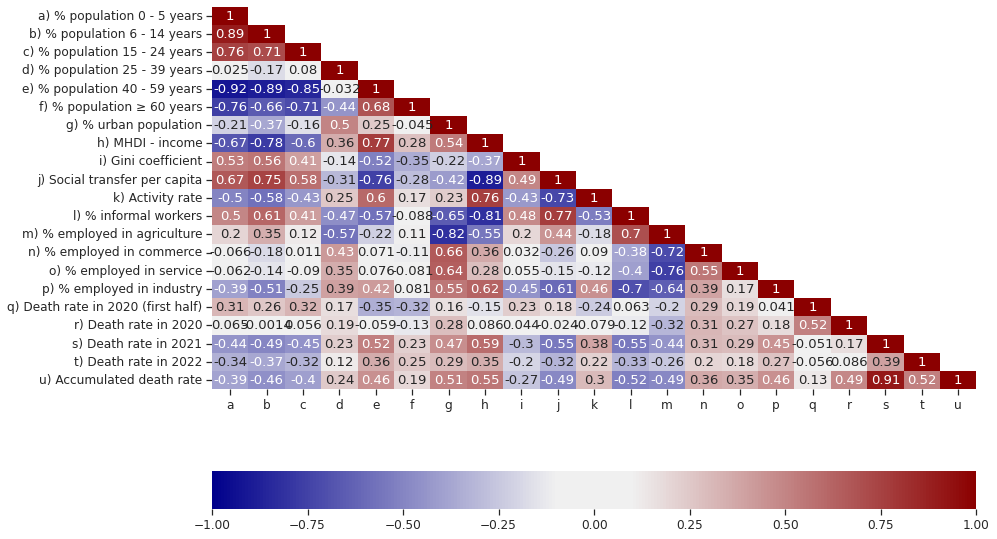

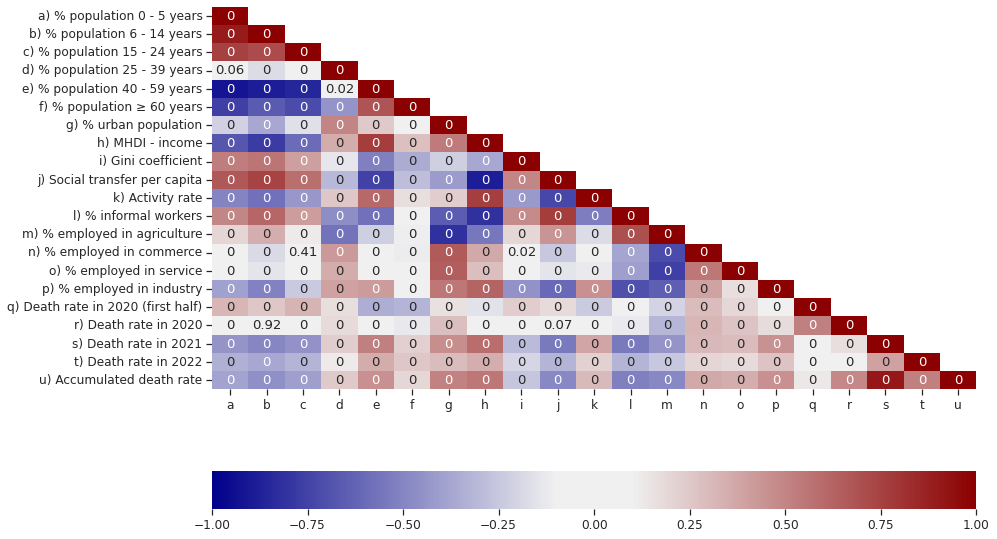

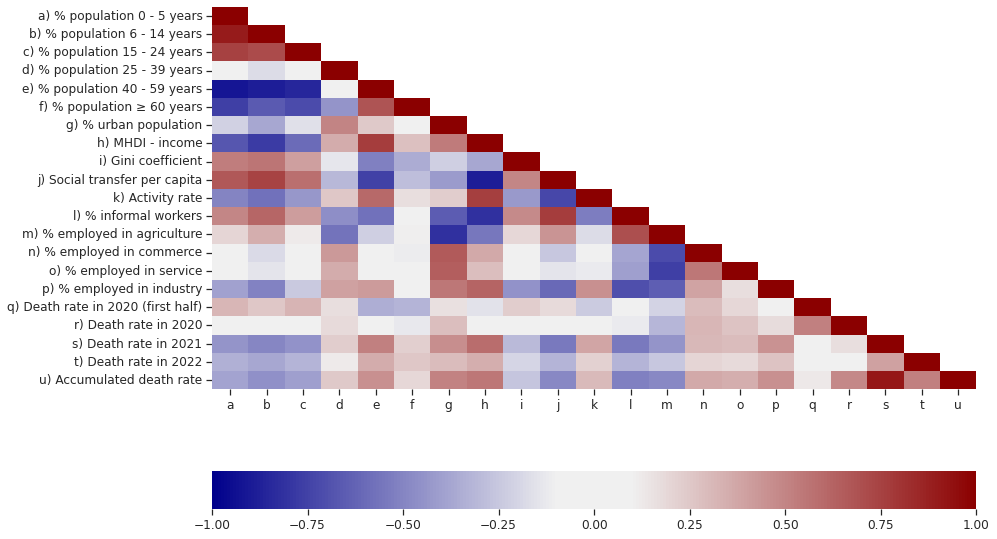

In [26]:
correlation, pvalue = spearmanr(df_selected_attributes)

pvalue = np.round(pvalue, 2)

mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask, k=1)] = True

largura = 34.8
altura = 25.52

sns.set(font_scale=1.1)
sns.set_style("ticks")

f, ax = plt.subplots(figsize=(util.centimeter_to_inch(largura), util.centimeter_to_inch(altura)))
ax = sns.heatmap(correlation, vmin=-1, vmax=1, center=0, square=False, mask=mask, cmap=palette,
                 yticklabels=yticklabels, xticklabels=xticklabels, annot=correlation,
                 cbar_kws={"orientation": "horizontal"}, cbar=True)
plt.xticks(rotation=0)
plt.show()

f, ax = plt.subplots(figsize=(util.centimeter_to_inch(largura), util.centimeter_to_inch(altura)))
ax = sns.heatmap(correlation, vmin=-1, vmax=1, center=0, square=False, mask=mask, cmap=palette,
                 yticklabels=yticklabels, xticklabels=xticklabels, annot=pvalue,
                 cbar_kws={"orientation": "horizontal"}, cbar=True)
plt.xticks(rotation=0)
plt.show()

f, ax = plt.subplots(figsize=(util.centimeter_to_inch(largura), util.centimeter_to_inch(altura)))
ax = sns.heatmap(correlation, vmin=-1, vmax=1, center=0, square=False, mask=mask, cmap=palette,
                 yticklabels=yticklabels, xticklabels=xticklabels, annot=False,
                 cbar_kws={"orientation": "horizontal"}, cbar=True)
plt.xticks(rotation=0)
plt.savefig('images/correlation_attributes_covid.pdf', bbox_inches="tight")
plt.savefig('images/correlation_attributes_covid.eps', bbox_inches="tight")
plt.show()